<a href="https://colab.research.google.com/github/samkirwanppb/UCDPA_SamKirwan/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [88]:
##importing packages needed for this project
from bs4 import BeautifulSoup as bs
import requests
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score, RepeatedKFold
from sklearn.datasets import make_regression
from sklearn.ensemble import AdaBoostRegressor

warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid") 
sns.color_palette("Spectral", as_cmap=True)
sns.set()

# Ratings Data Set

In [89]:
##the ratings data set contains the current ratings of all horses trained in Great Britain
ratings = pd.read_csv('https://raw.githubusercontent.com/samkirwanppb/UCDPA_SamKirwan/main/ratings.csv')
ratings = ratings.iloc[:, :-7] 
ratings = ratings.drop(columns = {'Diff Flat', 'Flat Clltrl', 'Diff AWT'})
ratings.head()

,Name,Year,Sex,Sire,Dam,Trainer,Flat rating,AWT rating
0,A BOY NAMED IVY (IRE),2018,GELDING,MARKAZ (IRE),ST ATHAN (GB),NaN,79.0,NaN
1,A DAY TO DREAM (IRE),2020,GELDING,ADAAY (IRE),TARA TOO (IRE),Ollie Pears,49.0,NaN
2,A DEFINITE GETAWAY (IRE),2018,GELDING,GETAWAY (GER),DEF IT VIC (IRE),Ben Pauling,NaN,NaN
3,A DIFFERENT KIND (IRE),2017,GELDING,DOYEN (IRE),MA MINX (IRE),Donald McCain,NaN,NaN
4,A E HOUSMAN (GB),2019,COLT,OASIS DREAM (GB),ASTRONOMY'S CHOICE (GB),NaN,82.0,NaN


In [90]:
ratings.shape

(12376, 8)

In [91]:
#gets the max values from the 2 columns and creats and new column with this value.
ratings['rating_final'] = ratings[['Flat rating', 'AWT rating']].max(axis = 1)
ratings.head()

,Name,Year,Sex,Sire,Dam,Trainer,Flat rating,AWT rating,rating_final
0,A BOY NAMED IVY (IRE),2018,GELDING,MARKAZ (IRE),ST ATHAN (GB),NaN,79.0,NaN,79.0
1,A DAY TO DREAM (IRE),2020,GELDING,ADAAY (IRE),TARA TOO (IRE),Ollie Pears,49.0,NaN,49.0
2,A DEFINITE GETAWAY (IRE),2018,GELDING,GETAWAY (GER),DEF IT VIC (IRE),Ben Pauling,NaN,NaN,NaN
3,A DIFFERENT KIND (IRE),2017,GELDING,DOYEN (IRE),MA MINX (IRE),Donald McCain,NaN,NaN,NaN
4,A E HOUSMAN (GB),2019,COLT,OASIS DREAM (GB),ASTRONOMY'S CHOICE (GB),NaN,82.0,NaN,82.0


In [92]:
###will use the above data to see how many horses a particular trainer has in training. this metric will also be used to predict horse ability. 
trainer = pd.DataFrame()

trainer = ratings.groupby('Trainer')['Name'].count().rename('trainer_horses').reset_index()##puts the count of trainers_horses and the trainers name into a df
trainer.head()

,Trainer,trainer_horses
0,A C Wilson,1
1,A. B. Leyshon,2
2,Adam Nicol,8
3,Adam West,25
4,Adrian Keatley,19


In [93]:
##merge in trainer horses column to the ratings dataset. 
ratings_trainer = ratings.merge(trainer, on = 'Trainer', how = 'left').drop(columns = {'Flat rating', 'AWT rating'}) 
ratings_trainer.head()

,Name,Year,Sex,Sire,Dam,Trainer,rating_final,trainer_horses
0,A BOY NAMED IVY (IRE),2018,GELDING,MARKAZ (IRE),ST ATHAN (GB),NaN,79.0,NaN
1,A DAY TO DREAM (IRE),2020,GELDING,ADAAY (IRE),TARA TOO (IRE),Ollie Pears,49.0,14.0
2,A DEFINITE GETAWAY (IRE),2018,GELDING,GETAWAY (GER),DEF IT VIC (IRE),Ben Pauling,NaN,69.0
3,A DIFFERENT KIND (IRE),2017,GELDING,DOYEN (IRE),MA MINX (IRE),Donald McCain,NaN,90.0
4,A E HOUSMAN (GB),2019,COLT,OASIS DREAM (GB),ASTRONOMY'S CHOICE (GB),NaN,82.0,NaN


# Performance Figures Data Set

In [94]:
##performance_ratings will be used to see if a horse has had 1,2,3,4,5 or 6+ runs
performance_figures = pd.read_csv('https://raw.githubusercontent.com/samkirwanppb/UCDPA_SamKirwan/main/performance_figures.csv')
performance_figures.head()

,Racehorse,YOF,Sex,Trainer,Latest,2 runs ago,3 runs ago,4 runs ago,5 runs ago,6 runs ago
0,A BOY NAMED IVY (IRE),2018,GELDING,NaN,T:73,T:79,T:72,T:63,T:74,T:80
1,A DAY TO DREAM (IRE),2020,GELDING,Ollie Pears,A:42,T:47,T:x,T:x,T:x,-
2,A DEFINITE GETAWAY (IRE),2018,GELDING,Ben Pauling,H:x,H:x,H:x,-,-,-
3,A DIFFERENT KIND (IRE),2017,GELDING,Donald McCain,H:93,H:135,H:x,H:x,H:x,H:x
4,A E HOUSMAN (GB),2019,COLT,NaN,T:71,A:x,A:x,T:x,T:x,-


In [95]:
##this function is used to remove the unwanted charactors H,S,N from the performance figures dataframe.
def clean_peformance_figures(data, column):  
  #first 3 lines remove national hunt data any run that contains the below charactors needs to be removed
  data = data[~data[column].str.contains("H")]
  data = data[~data[column].str.contains("S")]
  data = data[~data[column].str.contains("N")]
  data[column] = data[column].str.replace(":","").str.replace("T", "").str.replace("A","") ##this line cleans up the remaining data by removing the string elemetns to the peformance figures.
  return data

#this for loop iterates through the last 6 columns of the data and passes them into the user defined function created to clean the columns.
for i in performance_figures.columns[-6:]:
  performance_figures = clean_peformance_figures(performance_figures, i)

performance_figures = performance_figures.replace("-", np.nan)
performance_figures.head()

,Racehorse,YOF,Sex,Trainer,Latest,2 runs ago,3 runs ago,4 runs ago,5 runs ago,6 runs ago
0,A BOY NAMED IVY (IRE),2018,GELDING,NaN,73,79,72,63,74,80
1,A DAY TO DREAM (IRE),2020,GELDING,Ollie Pears,42,47,x,x,x,NaN
4,A E HOUSMAN (GB),2019,COLT,NaN,71,x,x,x,x,NaN
5,A LA FRANCAISE (GB),2019,FILLY,Jim Goldie,61,71,65,61,50,63
6,A LADY FOREVER (GB),2019,FILLY,Robyn Brisland,x,x,x,x,NaN,NaN


In [96]:
#use count of nan values in a given row for the last 6 columns to work out how many runs a horse has had in his carear. 
#note a value of 6 should really be 6+ as we dont know how many runs a horse may have had if there is already 6 records for them in this dataset. 
performance_figures['runs'] = 6 - performance_figures.iloc[:,-6:].isna().sum(axis = 1)
performance_figures.head() #we havce succesfully created the runs column which will be used in the model. 

,Racehorse,YOF,Sex,Trainer,Latest,2 runs ago,3 runs ago,4 runs ago,5 runs ago,6 runs ago,runs
0,A BOY NAMED IVY (IRE),2018,GELDING,NaN,73,79,72,63,74,80,6
1,A DAY TO DREAM (IRE),2020,GELDING,Ollie Pears,42,47,x,x,x,NaN,5
4,A E HOUSMAN (GB),2019,COLT,NaN,71,x,x,x,x,NaN,5
5,A LA FRANCAISE (GB),2019,FILLY,Jim Goldie,61,71,65,61,50,63,6
6,A LADY FOREVER (GB),2019,FILLY,Robyn Brisland,x,x,x,x,NaN,NaN,4


In [97]:
##I have merged ratings and the columns I want from peformance figures here
ratings_merged = ratings_trainer.merge(performance_figures[['Racehorse', 'runs']], left_on = 'Name', right_on = 'Racehorse').drop(columns = 'Racehorse')
ratings_merged.loc[(~ratings_merged['rating_final'].isna()) & (ratings_merged['runs'] <= 2), 'runs'] = np.nan ##this removes funny examples where horses where imported into GB already with a rating
ratings_merged.head()

,Name,Year,Sex,Sire,Dam,Trainer,rating_final,trainer_horses,runs
0,A BOY NAMED IVY (IRE),2018,GELDING,MARKAZ (IRE),ST ATHAN (GB),NaN,79.0,NaN,6.0
1,A DAY TO DREAM (IRE),2020,GELDING,ADAAY (IRE),TARA TOO (IRE),Ollie Pears,49.0,14.0,5.0
2,A E HOUSMAN (GB),2019,COLT,OASIS DREAM (GB),ASTRONOMY'S CHOICE (GB),NaN,82.0,NaN,5.0
3,A LA FRANCAISE (GB),2019,FILLY,POSTPONED (IRE),ALAMODE (GB),Jim Goldie,71.0,41.0,6.0
4,A LADY FOREVER (GB),2019,FILLY,ADAAY (IRE),LADY FILLY (GB),Robyn Brisland,42.0,35.0,4.0


# Yearling Sales Dataset

In [98]:
#this dataset contains the purchase price of race horses when they are yearlings (1 year old)
yearling_sales = pd.read_csv('https://raw.githubusercontent.com/samkirwanppb/UCDPA_SamKirwan/main/yearling_sales.csv').drop(columns = {'Purchaser', 'Consignor', 'Sex'})
yearling_sales.head()

,Year Foaled,Sire,Dam,Price (€),Price (£),Price (gns)
0,2020.0,Lope de Vega (IRE),Ebeyina (IRE),130000.0,NaN,NaN
1,2020.0,U S Navy Flag (USA),Edelline (IRE),36000.0,NaN,NaN
2,2020.0,Holy Roman Emperor (IRE),Elaysa (GB),90000.0,NaN,NaN
3,2020.0,No Nay Never (USA),Eldalil (GB),85000.0,NaN,NaN
4,2020.0,Churchill (IRE),Elizabelle (IRE),60000.0,NaN,NaN


In [99]:
#Data cleansing to merge into the main dataframe
yearling_sales['Sire'] = yearling_sales['Sire'].str.upper()
yearling_sales['Dam'] = yearling_sales['Dam'].str.upper()
yearling_sales = yearling_sales.dropna(subset = ['Year Foaled'])
yearling_sales['Year Foaled'] = yearling_sales['Year Foaled'].astype(int)

##getting them all in the one currency
yearling_sales.loc[~yearling_sales['Price (€)'].isna(), 'final_sale_price'] = yearling_sales.loc[~yearling_sales['Price (€)'].isna()]['Price (€)'] * 0.88
yearling_sales.loc[~yearling_sales['Price (gns)'].isna(), 'final_sale_price'] = yearling_sales.loc[~yearling_sales['Price (gns)'].isna()]['Price (gns)'] * 1.05
yearling_sales.loc[~yearling_sales['Price (£)'].isna(), 'final_sale_price'] = yearling_sales.loc[~yearling_sales['Price (£)'].isna()]['Price (£)'] * 1
yearling_sales = yearling_sales.drop(columns = ['Price (€)', 'Price (£)', 'Price (gns)'])## drop the price columns that are split by currency
yearling_sales.head()

,Year Foaled,Sire,Dam,final_sale_price
0,2020,LOPE DE VEGA (IRE),EBEYINA (IRE),114400.0
1,2020,U S NAVY FLAG (USA),EDELLINE (IRE),31680.0
2,2020,HOLY ROMAN EMPEROR (IRE),ELAYSA (GB),79200.0
3,2020,NO NAY NEVER (USA),ELDALIL (GB),74800.0
4,2020,CHURCHILL (IRE),ELIZABELLE (IRE),52800.0


In [100]:
ratings_final_sale = ratings_merged.merge(yearling_sales, left_on = ['Sire', 'Dam', 'Year'], right_on = ['Sire', 'Dam', 'Year Foaled'], how = 'left') #merge the yearling sales df with the ratings df
ratings_final_sale = ratings_final_sale.drop(columns = 'Year Foaled') #drop an unnessry column
ratings_final_sale.head()##note final price is in £

,Name,Year,Sex,Sire,Dam,Trainer,rating_final,trainer_horses,runs,final_sale_price
0,A BOY NAMED IVY (IRE),2018,GELDING,MARKAZ (IRE),ST ATHAN (GB),NaN,79.0,NaN,6.0,6160.0
1,A DAY TO DREAM (IRE),2020,GELDING,ADAAY (IRE),TARA TOO (IRE),Ollie Pears,49.0,14.0,5.0,4725.0
2,A E HOUSMAN (GB),2019,COLT,OASIS DREAM (GB),ASTRONOMY'S CHOICE (GB),NaN,82.0,NaN,5.0,NaN
3,A LA FRANCAISE (GB),2019,FILLY,POSTPONED (IRE),ALAMODE (GB),Jim Goldie,71.0,41.0,6.0,52500.0
4,A LADY FOREVER (GB),2019,FILLY,ADAAY (IRE),LADY FILLY (GB),Robyn Brisland,42.0,35.0,4.0,NaN


# Yearling Sales Sires 


In [101]:
#similar data to the above data set except this set is grouped by sire and includes data from more sales then the set above.
yearling_sales_sires = pd.read_csv('https://raw.githubusercontent.com/samkirwanppb/UCDPA_SamKirwan/main/yearling_sales_sires.csv')
median_yearling_sales = yearling_sales_sires.loc[yearling_sales_sires['year'] == 2022][['Stallion', 'Med. £']].replace(',','', regex=True)
median_yearling_sales.head() ##the stallion name is formated different to the ratings_final_sale df which I will have to clean in order to merge

,Stallion,Med. £
0,Dubawi,669375
3,Frankel,338123
4,Kingman,283500
5,Galileo,259307
7,Siyouni,181741


In [102]:
median_yearling_sales['Stallion'] = median_yearling_sales['Stallion'].str.capitalize() ##funny examples of Lope de Vega where some are capitals and some are not. sire_merge uses capitalize so best to use that here too
ratings_final_sale['sire_merge'] = ratings_final_sale['Sire'].str.split("(").str[0].str.strip().str.capitalize()
merged_data = ratings_final_sale.merge(median_yearling_sales, left_on = 'sire_merge', right_on = 'Stallion', how = 'left')
merged_data = merged_data.drop(columns = ['Stallion']).rename(columns = {'Med. £' : 'Sire_median_yearling_price'})#makes the median price more readable
merged_data['Sire_median_yearling_price'] = merged_data['Sire_median_yearling_price'].astype(float)
merged_data.head()

,Name,Year,Sex,Sire,Dam,Trainer,rating_final,trainer_horses,runs,final_sale_price,sire_merge,Sire_median_yearling_price
0,A BOY NAMED IVY (IRE),2018,GELDING,MARKAZ (IRE),ST ATHAN (GB),NaN,79.0,NaN,6.0,6160.0,Markaz,NaN
1,A DAY TO DREAM (IRE),2020,GELDING,ADAAY (IRE),TARA TOO (IRE),Ollie Pears,49.0,14.0,5.0,4725.0,Adaay,9023.0
2,A E HOUSMAN (GB),2019,COLT,OASIS DREAM (GB),ASTRONOMY'S CHOICE (GB),NaN,82.0,NaN,5.0,NaN,Oasis dream,44100.0
3,A LA FRANCAISE (GB),2019,FILLY,POSTPONED (IRE),ALAMODE (GB),Jim Goldie,71.0,41.0,6.0,52500.0,Postponed,6074.0
4,A LADY FOREVER (GB),2019,FILLY,ADAAY (IRE),LADY FILLY (GB),Robyn Brisland,42.0,35.0,4.0,NaN,Adaay,9023.0


# Sire Fee Dataset - Data Cleaning / Web Scraping


In [103]:
###start of scraping the below site was found after inspecting the irish field website
hsite = "https://e.infogram.com/_/bQHbMUkcBdD1LFGscrW5?parent_url=https%3A%2F%2Fwww.theirishfield.ie%2Fstallion-fees-up-to-date-fees-for-more-than-400-stallions-for-2023-738173&src=embed#async_embed"
res = requests.get(hsite)
soup = bs(res.content, "html.parser")
#soup

text = soup.find_all("script")[4]
##regex looks a good start to clean the data

string = str(text)
print(string[2000:4000])#sample of scraped string

(NEW)"],["Blue Point","Kildangan","€35,000 (€40,000)"],["Bungle Inthejungle","Rathasker","€6,500 (€8,000)"],["Calyx","Coolmore","€10,000 (€12,500)"],["Camelot","Coolmore","€60,000 (€75,000)"],["Churchill","Coolmore","€30,000 (€25,000)"],["Circus Maximus","Coolmore","€10,000 (€12,500)"],["Cotai Glory","Tally-Ho","€12,500 (€8,500)"],["Coulsty","Rathasker","€4,500 (€4,000)"],["Court Cave","Boardsmill","€4,000 (€4,000)"],["Dandy Man","Ballyhane","€15,000 (€15,000)"],["Dark Angel","Morristown Lattin","€60,000 (€60,000)"],["Dawn Approach","Redmondstown","€5,000 (€10,000)"],["Dee Ex Bee","Arctic Tack","€3,500 (€3,500)"],["Decorated Knight","Irish National","€5,000 (€7,500)"],["Dragon Pulse","Irish National","€2,000 (€2,000)"],["Earthlight","Kildangan","€15,000 (€18,000)"],["Elusive Pimpernel","Irish National","€2,000 (€2,000)"],["Elzaam","Ballyhane","€4,000 (€5,000)"],["Equiano","Irish National","€2,000 (€2,000)"],["Far Above","Starfield","€5,000 (€5,000)"],["Feel Like Dancing","Whytemount","

In [104]:
##regex explanation: I use \ to escape the [ charactor as that has a special use case in regex. ( starts a group of the charactors we would like to capture ) ends the group. 
## .*? is a lazy form of pattern matching. it is matching all charactors that are not a new line after a [ one or 0 times.
## and \] is telling it to stop once it has reached the next ].
##so what is returned is a list of all the charactors that fall between a set of [] in the html.

raw_data = re.findall(r'\[(.*?)\]', string) ## this regex returns a list of all strings that start with "[" and end with "]" and pulls everything in between
raw_data[15:20]

['"Cotai Glory","Tally-Ho","€12,500 (€8,500)"',
 '"Coulsty","Rathasker","€4,500 (€4,000)"',
 '"Court Cave","Boardsmill","€4,000 (€4,000)"',
 '"Dandy Man","Ballyhane","€15,000 (€15,000)"',
 '"Dark Angel","Morristown Lattin","€60,000 (€60,000)"']

In [105]:
##the below is a reusable function. When inputting the list returned from the regex pattern this will return the desired elements that we would like to keep
def clean_data(data):
  data_filtered = []
  for i in data:
    if len(i) != 0: ##removes empty strings in the list 
        if i[0] == '"' and i[-2:] == ')"': ##these are the charactorists of the strings that we want to keep. any string that starts with a "" and its 2nd last string is a ) then it contains data relatied to a stallion
            i = i.replace('"', '')#removing all the " from the data
            data_filtered.append(i)

  return data_filtered

data_lst = clean_data(raw_data)

print(data_lst[0:5])#list now contains strigns of data that we want

['Acclamation,Rathbarry,€27,500 (€27,500)', 'Alkumait,Castlefield,€5,000 (€5,000)', 'Arizona,Coolmore,€5,000 (€6,000)', 'Australia,Coolmore,€25,000 (€35,000)', 'Awtaad,Derrinstown,€5,000 (€5,000)']


In [106]:
##putting the data into a dictionary
data_dic = {}
for i in data_lst:
  #the key of the dictionary is the first part of the list produced when splitting the passed string by ,
  data_dic[i.split(",", 2)[0]] = [i.split(",", 2)[1],i.split(",", 2)[2]] # each key has a string containing 2 elements. the location of the stud and the fee data for the stallion.

col = ['Sire','Stud', 'Fee'] #setting the columns for the dataframe that we are going to covert the dictionary into.
fee_data = pd.DataFrame.from_dict(data_dic, orient='index').reset_index()
fee_data.set_axis(col, axis = 1, inplace = True)
fee_data.head()

,Sire,Stud,Fee
0,Acclamation,Rathbarry,"€27,500 (€27,500)"
1,Alkumait,Castlefield,"€5,000 (€5,000)"
2,Arizona,Coolmore,"€5,000 (€6,000)"
3,Australia,Coolmore,"€25,000 (€35,000)"
4,Awtaad,Derrinstown,"€5,000 (€5,000)"


In [107]:
##cleaning the fee column. the first price is the 2023 years fee, the price in brackets is the 2022 fee (last year)
fee_data['Fee 2023'] = fee_data['Fee'].str.split("(").str[0].str.strip()
fee_data['Fee 2022'] = fee_data['Fee'].str.split("(").str[1].str.strip().str.replace(")", "")
fee_data = fee_data.loc[~(fee_data['Fee'].str.contains('A\$'))]#remove australian stallions, had to use the escape charactor for the dollar sign, in plain english we are removing strings containing A$
fee_data = fee_data.loc[~(fee_data['Fee'].str.contains('Private'))] #remove sires that have a private fee. they do not offer us quantitive data and should be removed.
fee_data.head()

,Sire,Stud,Fee,Fee 2023,Fee 2022
0,Acclamation,Rathbarry,"€27,500 (€27,500)","€27,500","€27,500"
1,Alkumait,Castlefield,"€5,000 (€5,000)","€5,000","€5,000"
2,Arizona,Coolmore,"€5,000 (€6,000)","€5,000","€6,000"
3,Australia,Coolmore,"€25,000 (€35,000)","€25,000","€35,000"
4,Awtaad,Derrinstown,"€5,000 (€5,000)","€5,000","€5,000"


In [108]:
fee_data['Fee 2022'].value_counts().head() ##we can see there is an akward instance of the value "NEW"
##NEW means the stallion is new to stud and therefore didnt have a fee for 2022.

NEW        34
€5,000     22
$10,000    16
€15,000    10
€4,000      9
Name: Fee 2022, dtype: int64

In [109]:
#replacing the new value with nans as some sires did not have a fee in 2022 it is appropriate to replace the New values with np.nan.
fee_data['Fee 2022'] = fee_data['Fee 2022'].replace('NEW', np.nan)
fee_data['Fee 2022'].value_counts().head()#new is gone and replaced with NP.nan

€5,000     22
$10,000    16
€15,000    10
€4,000      9
$15,000     8
Name: Fee 2022, dtype: int64

In [110]:
##as can be seen in the above code the fee columns still need some cleaning. also an important observation is that the currencyies for the fees are different for certain stallions
#so I will create a column that stores the currencies so that we can convert them all into the one
fee_data['Currency 2023'] = fee_data['Fee 2023'].str[0] 
fee_data['Currency 2022'] = fee_data['Fee 2022'].str[0]
#clean the Fee 2022 and Fee 2023 columns so that they are floats
fee_data['Fee 2023'] = fee_data['Fee 2023'].str.replace("€", "").str.replace("£", "").str.replace("$", "") #strip out all of the currency symbols out of the strings
fee_data['Fee 2022'] = fee_data['Fee 2022'].str.replace("€", "").str.replace("£", "").str.replace("$", "") #strip out all of the currency symbols out of the strings
fee_data = fee_data.replace(',','', regex=True) #remove all commas by replacing them with "". data is now in a form to converted into floats


In [111]:
fee_data[['Fee 2022','Fee 2023']] = fee_data[['Fee 2022','Fee 2023']].astype(float) #convert to floats

fee_data.loc[(~fee_data['Fee 2023'].isna()) & (fee_data['Currency 2023'] == '€'), 'Fee_2023_final'] = fee_data.loc[~fee_data['Fee 2023'].isna()]['Fee 2023'] * 0.88 #convert to GBP
fee_data.loc[(~fee_data['Fee 2022'].isna()) & (fee_data['Currency 2022'] == '€'), 'Fee_2022_final'] = fee_data.loc[~fee_data['Fee 2022'].isna()]['Fee 2022'] * 0.88 #convert to GBP

fee_data.loc[(~fee_data['Fee 2023'].isna()) & (fee_data['Currency 2023'] == '$'), 'Fee_2023_final'] = fee_data.loc[~fee_data['Fee 2023'].isna()]['Fee 2023'] * 0.83 #convert to GBP
fee_data.loc[(~fee_data['Fee 2022'].isna()) & (fee_data['Currency 2022'] == '$'), 'Fee_2022_final'] = fee_data.loc[~fee_data['Fee 2022'].isna()]['Fee 2022'] * 0.83 #convert to GBP

#fee_data[['Fee 2022', 'Fee 2023']] = fee_data[['Fee 2022', 'Fee 2023']].fillna(0).astype(int).replace(0, np.nan) 
#commented out the above for now. it looks unnesary. will remove completly of notebook runs smoothly.
fee_data.head() #have clean data scraped from the web in the formate that we require

,Sire,Stud,Fee,Fee 2023,Fee 2022,Currency 2023,Currency 2022,Fee_2023_final,Fee_2022_final
0,Acclamation,Rathbarry,€27500 (€27500),27500.0,27500.0,€,€,24200.0,24200.0
1,Alkumait,Castlefield,€5000 (€5000),5000.0,5000.0,€,€,4400.0,4400.0
2,Arizona,Coolmore,€5000 (€6000),5000.0,6000.0,€,€,4400.0,5280.0
3,Australia,Coolmore,€25000 (€35000),25000.0,35000.0,€,€,22000.0,30800.0
4,Awtaad,Derrinstown,€5000 (€5000),5000.0,5000.0,€,€,4400.0,4400.0


In [112]:
fee_data = fee_data[['Sire', 'Fee_2023_final']]#keeping the columns we need for the main data set
fee_data['Sire'] = fee_data['Sire'].str.capitalize() ##putting in the same format to merge using the sire_merge column
fee_data.head(8)

,Sire,Fee_2023_final
0,Acclamation,24200.0
1,Alkumait,4400.0
2,Arizona,4400.0
3,Australia,22000.0
4,Awtaad,4400.0
5,Bayside boy,13200.0
6,Behesht,1320.0
7,Blackbeard,22000.0


In [113]:
data = merged_data.merge(fee_data, left_on = 'sire_merge', right_on = 'Sire', how = 'left').drop(columns = 'Sire_y').rename(columns = {'Sire_x': 'Sire'})
data.head() ##we now have a clean data set containing all the columns from each data set that we desire.            

,Name,Year,Sex,Sire,Dam,Trainer,rating_final,trainer_horses,runs,final_sale_price,sire_merge,Sire_median_yearling_price,Fee_2023_final
0,A BOY NAMED IVY (IRE),2018,GELDING,MARKAZ (IRE),ST ATHAN (GB),NaN,79.0,NaN,6.0,6160.0,Markaz,NaN,NaN
1,A DAY TO DREAM (IRE),2020,GELDING,ADAAY (IRE),TARA TOO (IRE),Ollie Pears,49.0,14.0,5.0,4725.0,Adaay,9023.0,4400.0
2,A E HOUSMAN (GB),2019,COLT,OASIS DREAM (GB),ASTRONOMY'S CHOICE (GB),NaN,82.0,NaN,5.0,NaN,Oasis dream,44100.0,NaN
3,A LA FRANCAISE (GB),2019,FILLY,POSTPONED (IRE),ALAMODE (GB),Jim Goldie,71.0,41.0,6.0,52500.0,Postponed,6074.0,NaN
4,A LADY FOREVER (GB),2019,FILLY,ADAAY (IRE),LADY FILLY (GB),Robyn Brisland,42.0,35.0,4.0,NaN,Adaay,9023.0,4400.0


# Dataset Description/Overview

In [114]:
##final dataset description
data.shape

(7478, 13)

In [115]:
data.describe()

,Year,rating_final,trainer_horses,runs,final_sale_price,Sire_median_yearling_price,Fee_2023_final
count,7478.000000,7458.000000,4975.000000,7340.000000,2.670000e+03,5052.000000,2696.000000
mean,2018.328698,69.032046,37.964623,5.384469,6.726686e+04,67020.989311,36460.259644
std,1.678526,17.782760,28.337289,1.082698,1.349855e+05,111324.632717,42547.421129
min,2009.000000,10.000000,1.000000,0.000000,8.400000e+02,2822.000000,880.000000
25%,2018.000000,56.000000,16.000000,5.000000,1.680000e+04,17042.000000,6600.000000
50%,2019.000000,68.000000,31.000000,6.000000,3.675000e+04,34205.000000,15400.000000
75%,2019.000000,80.000000,51.000000,6.000000,7.447500e+04,52500.000000,52800.000000
max,2020.000000,124.000000,123.000000,6.000000,3.780000e+06,669375.000000,186750.000000


In [116]:
data.isna().sum() ##we can see that there is alot of missing values for Fee_2023_final and final_sale_price

Name                             0
Year                             0
Sex                              0
Sire                             0
Dam                              0
Trainer                       2503
rating_final                    20
trainer_horses                2503
runs                           138
final_sale_price              4808
sire_merge                       0
Sire_median_yearling_price    2426
Fee_2023_final                4782
dtype: int64

In [117]:
##The aim of this project will be to use supervised learning to predict a horses ability.
# A horses ability is represented by its rating. A horse that has a higher rating is a better horse then a horse with a lower rating

In [118]:
###having a look at the correaltion between variables for the data set
data[['Year', 'rating_final',
        'trainer_horses', 'runs', 'final_sale_price',
        'Sire_median_yearling_price', 'Fee_2023_final']].corr() #can see the biggest correlation with rating final is trainer_horses, final_sale_price and sire_median_yearling_price
##we can also see the massive correlation between Sire_median_yearling_price and Fee_2023_final, this will have to be taken into when fitting a model.

,Year,rating_final,trainer_horses,runs,final_sale_price,Sire_median_yearling_price,Fee_2023_final
Year,1.000000,0.038402,0.111753,-0.400560,-0.040172,-0.041065,-0.067358
rating_final,0.038402,1.000000,0.219353,0.009096,0.259335,0.264036,0.255346
trainer_horses,0.111753,0.219353,1.000000,-0.072829,0.058183,0.055977,0.107057
runs,-0.400560,0.009096,-0.072829,1.000000,-0.054189,-0.031725,-0.019675
final_sale_price,-0.040172,0.259335,0.058183,-0.054189,1.000000,0.508414,0.404185
Sire_median_yearling_price,-0.041065,0.264036,0.055977,-0.031725,0.508414,1.000000,0.949513
Fee_2023_final,-0.067358,0.255346,0.107057,-0.019675,0.404185,0.949513,1.000000


In [119]:
## aslo looking at the rating_final row of the above dataframe we can see the treiner_horses, final_sale_price, Sire_median_yearling_priceand Fee_2023_final have the highest correlation with horse ability
#this leads to 2 problems. the volumn of missing data for final_sale_price and fee 2023 final.
#the 2nd problem is multicolinearity

#in order to solve this problem I will create a new column column called yearling_value

# Creating yearling_value column - In order to replace missing final price values

In [120]:
## Using domain knowledge certain trainers buy different types of yearlings and its important to incorporpate an element of the trainers purchasing power into the new yearling_value column.
#taking into account the trainers median purchase price will improve the accuracy of the yearling_value column

In [121]:
## in order to reduce the number of nans in the final_price column I will use trainers median purchase price to est how much a yearling would have cost. 
med_trainer_price = data.groupby('Trainer')['final_sale_price'].median().rename('median_trainer_price').reset_index()
med_trainer_price.head()

,Trainer,median_trainer_price
0,Adam Nicol,31500.0
1,Adam West,15810.0
2,Adrian Keatley,20000.0
3,Adrian Nicholls,21560.0
4,Adrian Wintle,20520.0


In [122]:
data_df = data.merge(med_trainer_price, how = 'left', on = 'Trainer')
data_df.head()

,Name,Year,Sex,Sire,Dam,Trainer,rating_final,trainer_horses,runs,final_sale_price,sire_merge,Sire_median_yearling_price,Fee_2023_final,median_trainer_price
0,A BOY NAMED IVY (IRE),2018,GELDING,MARKAZ (IRE),ST ATHAN (GB),NaN,79.0,NaN,6.0,6160.0,Markaz,NaN,NaN,NaN
1,A DAY TO DREAM (IRE),2020,GELDING,ADAAY (IRE),TARA TOO (IRE),Ollie Pears,49.0,14.0,5.0,4725.0,Adaay,9023.0,4400.0,4725.0
2,A E HOUSMAN (GB),2019,COLT,OASIS DREAM (GB),ASTRONOMY'S CHOICE (GB),NaN,82.0,NaN,5.0,NaN,Oasis dream,44100.0,NaN,NaN
3,A LA FRANCAISE (GB),2019,FILLY,POSTPONED (IRE),ALAMODE (GB),Jim Goldie,71.0,41.0,6.0,52500.0,Postponed,6074.0,NaN,35000.0
4,A LADY FOREVER (GB),2019,FILLY,ADAAY (IRE),LADY FILLY (GB),Robyn Brisland,42.0,35.0,4.0,NaN,Adaay,9023.0,4400.0,5170.0


In [123]:
##finally to get the estimate of a yearlings value I will take the mean of 'median_trainer_price', 'Sire_median_yearling_price' and 'Fee_2023_final'
data_df['est_yearling_value'] = data_df[['median_trainer_price', 'Sire_median_yearling_price', 'Fee_2023_final']].mean(axis=1) 

In [124]:
## as final_price is the actual value the yearling was sold for it is the most accurate estimator and I will use that value rather then the estmiated one above.
#I will overwrite the est_yearling_value column with final_sale_price where the data exists
data_df.loc[~data_df['final_sale_price'].isna(), 'est_yearling_value'] = data_df.loc[~data_df['final_sale_price'].isna()]['final_sale_price']

In [125]:
data_df.isna().sum() #we know only have 794 missing values for final_sale_price_est

Name                             0
Year                             0
Sex                              0
Sire                             0
Dam                              0
Trainer                       2503
rating_final                    20
trainer_horses                2503
runs                           138
final_sale_price              4808
sire_merge                       0
Sire_median_yearling_price    2426
Fee_2023_final                4782
median_trainer_price          2806
est_yearling_value             794
dtype: int64

In [126]:
###checking new column for correlation
data_df[['Year', 'rating_final',
        'trainer_horses', 'runs', 'est_yearling_value']].corr() ##trainer_horses and est_yearling_value have the highest correlation. runs has little to no correlation. year seams to have little correlation

,Year,rating_final,trainer_horses,runs,est_yearling_value
Year,1.000000,0.038402,0.111753,-0.400560,0.041669
rating_final,0.038402,1.000000,0.219353,0.009096,0.276119
trainer_horses,0.111753,0.219353,1.000000,-0.072829,0.055842
runs,-0.400560,0.009096,-0.072829,1.000000,-0.071447
est_yearling_value,0.041669,0.276119,0.055842,-0.071447,1.000000


In [127]:
##will also remove some redundant columns now
data_df = data_df.drop(columns = {'Trainer', 'Dam', 'Fee_2023_final', 'Sire_median_yearling_price', 'median_trainer_price', 'sire_merge'})
data_df.head()

,Name,Year,Sex,Sire,rating_final,trainer_horses,runs,final_sale_price,est_yearling_value
0,A BOY NAMED IVY (IRE),2018,GELDING,MARKAZ (IRE),79.0,NaN,6.0,6160.0,6160.000000
1,A DAY TO DREAM (IRE),2020,GELDING,ADAAY (IRE),49.0,14.0,5.0,4725.0,4725.000000
2,A E HOUSMAN (GB),2019,COLT,OASIS DREAM (GB),82.0,NaN,5.0,NaN,44100.000000
3,A LA FRANCAISE (GB),2019,FILLY,POSTPONED (IRE),71.0,41.0,6.0,52500.0,52500.000000
4,A LADY FOREVER (GB),2019,FILLY,ADAAY (IRE),42.0,35.0,4.0,NaN,6197.666667


#est_yearling_value - EDA

[Text(0.5, 0, 'Estimated Yearling Value'), Text(0.5, 1.0, 'Histogram')]

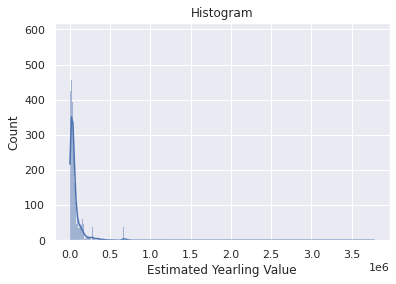

In [128]:
sns.histplot(data = data_df, x = 'est_yearling_value', kde = True).set(xlabel = 'Estimated Yearling Value', title = 'Histogram') #data is clearly skewed right like most cost distributions

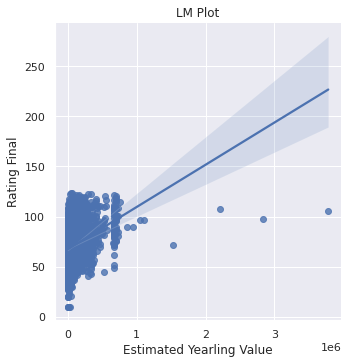

In [129]:
sns.lmplot(data = data_df, x = 'est_yearling_value', y = 'rating_final').set(xlabel = 'Estimated Yearling Value', ylabel = 'Rating Final', title = 'LM Plot')

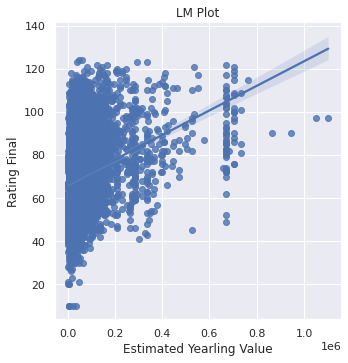

In [130]:
#we can see in the above graph that final_sale_price_est has 4 outliers that cose more then 1,200,000. If we were to included these in the model the predicted final rating would be way over the max rating that exits in this data set of 124.
#should probably do a bit on testing the outliers effecting the model.
data_df = data_df.loc[data_df['est_yearling_value'] < 1200000]
sns.lmplot(data = data_df, x = 'est_yearling_value', y = 'rating_final').set(xlabel = 'Estimated Yearling Value', ylabel = 'Rating Final', title = 'LM Plot')

In [131]:
## we can see in the above plot there is a clear correlation between rating_final and est_yealing value but the skewed est_yearlin_value column goes against the assumptions of linear regression
#will aim to transform this variable.
data_df['est_yearling_value'].min() #no negetive or 0 values. can use log to transform

840.0

[Text(0.5, 0, 'Estimated Yealing Value'), Text(0, 0.5, 'Horse Rating')]

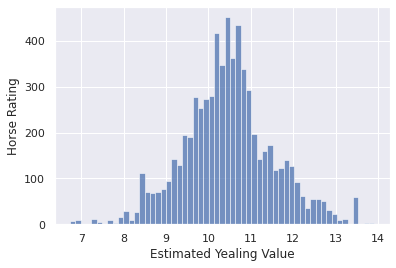

In [132]:
sns.histplot(data= np.log(data_df['est_yearling_value'])).set(
    xlabel='Estimated Yealing Value', 
    ylabel='Horse Rating') #data is now normally distributed so I will create the new variable - log_est_yearling_value

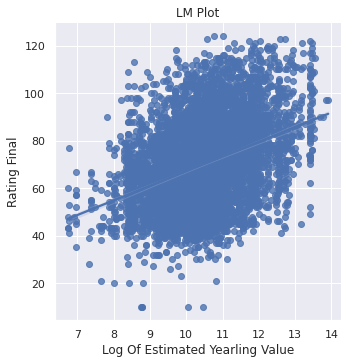

In [133]:
data_df['log_est_yearling_value'] = np.log(data_df['est_yearling_value'])
sns.lmplot(data = data_df, x = 'log_est_yearling_value', y = 'rating_final').set(xlabel = 'Log Of Estimated Yearling Value', ylabel = 'Rating Final', title = 'LM Plot')

In [134]:
##Taken from DC
##person correltaion stats.
def pearson_r(x,y):
    ##"""Compute Pearson correlation coefficient between two arrays."""
    # Compute correlation matrix: corr_mat
    corr_mat = np.corrcoef([x,y])

    # Return entry [0,1]
    return corr_mat[0,1]

# Compute Pearson correlation coefficient for I. versicolor: r
data_df_no_nans = data_df.loc[~(data_df['log_est_yearling_value'].isna()) & ~(data_df['rating_final'].isna())]
r = pearson_r(data_df_no_nans['log_est_yearling_value'], data_df_no_nans['rating_final'])

# Print the result
print(r) #there is decent correlation

0.3692679117107094


# Year/Horse Age


<AxesSubplot:xlabel='Year', ylabel='Count'>

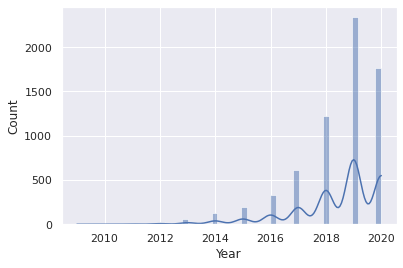

In [135]:
sns.histplot(data = data_df, x = 'Year', kde = True)

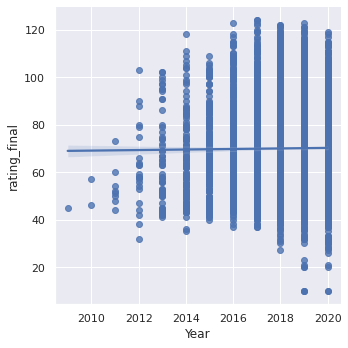

In [136]:
##look at year variable
##eda of new final_sale_price_est column
sns.lmplot(data = data_df, x = 'Year', y = 'rating_final')  # there doesnt seem to exist a meaningful relationship between the 2 variables. 

In [137]:
# Pearson correlation coefficient 
data_df_no_nans = data_df.loc[~(data_df['Year'].isna()) & ~(data_df['rating_final'].isna())]
r = pearson_r(data_df_no_nans['Year'], data_df_no_nans['rating_final'])

print(r) 
#tiny correlation not neccesaryily one to include 

0.010276557661645402


#Trainers Horses/Trainer Size


[Text(0.5, 0, 'Trainers Horses'), Text(0.5, 1.0, 'Histogram')]

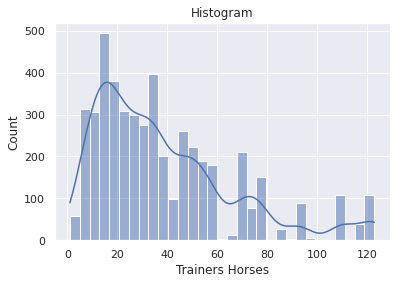

In [138]:
sns.histplot(data = data_df, x = 'trainer_horses', kde = True).set(xlabel = 'Trainers Horses', title = 'Histogram') #again there is signs of the data being skewed

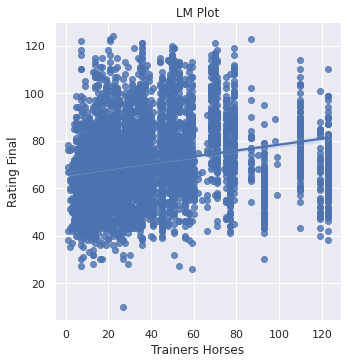

In [139]:
sns.lmplot(data = data_df, x = 'trainer_horses', y = 'rating_final').set(xlabel = 'Trainers Horses', ylabel = 'Rating Final', title = 'LM Plot') ##again there seems to be a relationship. so I will try normalize the distribution

In [140]:
## we can see in the above plot there is a clear correlation between rating_final and trainer_horses but the skewed est_yearlin_value column goes against the assumptions of linear regression
#will aim to transform this variable.
data_df['trainer_horses'].min() #no negetive or 0 values. can use log to transform

1.0

[Text(0.5, 0, 'Trainers Horses')]

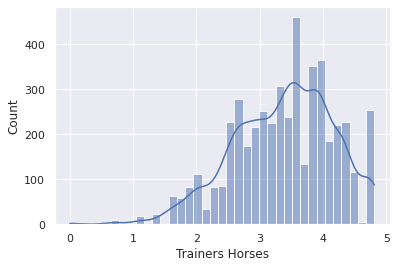

In [141]:
sns.histplot(data= np.log(data_df['trainer_horses']), kde = True).set(xlabel = 'Trainers Horses') ## more normal looing

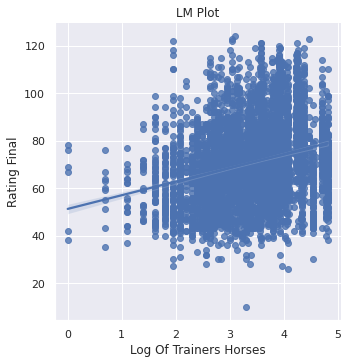

In [142]:
data_df['log_trainer_horses'] = np.log(data_df['trainer_horses'])
sns.lmplot(data = data_df, x = 'log_trainer_horses', y = 'rating_final').set(xlabel = 'Log Of Trainers Horses', ylabel = 'Rating Final', title = 'LM Plot') ##again there semms to be correlation

In [143]:
# Compute Pearson correlation coefficient
data_df_no_nans = data_df.loc[~(data_df['log_trainer_horses'].isna()) & ~(data_df['rating_final'].isna())]
r = pearson_r(data_df_no_nans['log_trainer_horses'], data_df_no_nans['rating_final'])

# Print the result
print(r) #there is decent correlation again - positive correlation the bigger the stable the better the horse

0.2658454473774699


In [144]:
##Hpyothesis test of correlation - taken from DC
# Compute observed correlation: r_obs
r_obs = pearson_r(data_df_no_nans['log_trainer_horses'], data_df_no_nans['rating_final'])

# Initialize permutation replicates: perm_replicates
perm_replicates = np.empty(10000)

# Draw replicates
for i in range(10000):
    # Permute illiteracy measurments: illiteracy_permuted
    log_trainer_horses_permuted = np.random.permutation(data_df_no_nans['log_trainer_horses'])

    # Compute Pearson correlation
    perm_replicates[i] = pearson_r(log_trainer_horses_permuted, data_df_no_nans['rating_final'])

# Compute p-value: p
p = np.sum(perm_replicates >= r_obs) / len(perm_replicates)
print('p-val =', p, 'r_obs = ', r_obs) #p value of 0 means the correltion has a 0% chance of existing due to ranomness

p-val = 0.0 r_obs =  0.2658454473774699


[Text(0.5, 0, 'P Values'), Text(0.5, 1.0, 'Histogram')]

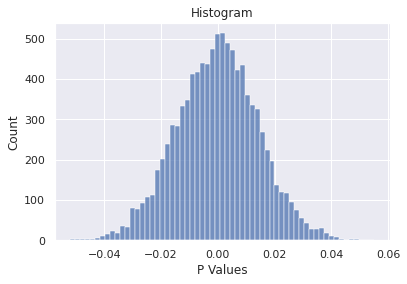

In [145]:
sns.histplot(perm_replicates).set(xlabel = 'P Values', title = 'Histogram') ##all below our observed Person correlation of 0.27 # ranomness can be ruled out as an explantion to the correlation that exists.

#Sex - Categorical Variable 

In [146]:
## Gelding is a castrated colt. could be best treated as one.
data_df.groupby('Sex')['rating_final'].count()

Sex
COLT        926
FILLY      2382
GELDING    3362
Name: rating_final, dtype: int64

[Text(0.5, 0, 'Sex'), Text(0, 0.5, 'Horse Rating'), Text(0.5, 1.0, 'Box Plot')]

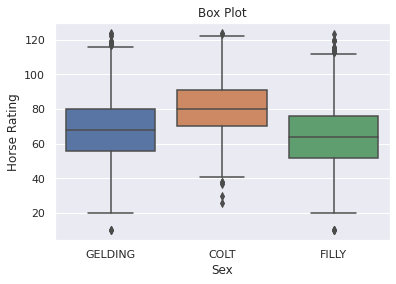

In [147]:
sns.boxplot(data=data, x='Sex', y='rating_final').set(xlabel='Sex', ylabel='Horse Rating', title = 'Box Plot')
#there looks to be a difference between colts and the other 2 sexs. 

In [148]:
data_df.groupby('Sex')['rating_final'].agg(['mean', 'median'])

,mean,median
Sex,,
COLT,81.003240,80.0
FILLY,66.331234,65.0
GELDING,69.647829,69.0


[Text(0, 0.5, 'Rating Final'),
 Text(0.5, 1.0, 'Mean and Median Of Final Rating by Sex')]

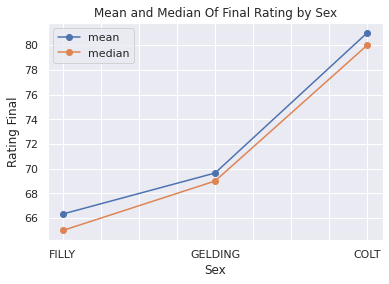

In [149]:
data_df.groupby('Sex')['rating_final'].agg(['mean', 'median']).sort_values('mean').plot(marker = 'o').set(ylabel = 'Rating Final', title = 'Mean and Median Of Final Rating by Sex') 
## looking at the below plot it seems there is a differnece between fillys and geldings, however I will use bootstraping and an hypothesis test to make sure

In [150]:
##the above graph leads me to want to investigate the difference between fillys and geldings.
fillys = data_df.loc[data_df['Sex'] == 'FILLY']['rating_final']
geldings = data_df.loc[data_df['Sex'] == 'GELDINGS']['rating_final']

# Compute mean of combined data set: combined_mean
combined_mean = np.mean(np.concatenate((fillys, geldings)))

# Shift the samples
fillys_shifted = fillys - np.mean(fillys) + combined_mean
geldings_shifted = geldings - np.mean(geldings) + combined_mean


def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    def bootstrap_replicate_1d(data, func):
      """Generate bootstrap replicate of 1D data."""
      bs_sample = np.random.choice(data, len(data))
      return func(bs_sample)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)

    return bs_replicates

# Get bootstrap replicates of shifted data sets
bs_replicates_fillys= draw_bs_reps(fillys_shifted, np.mean, 10000)
bs_replicates_geldings = draw_bs_reps(geldings_shifted, np.mean, 10000)

# Compute replicates of difference of means: bs_diff_replicates
bs_diff_replicates = bs_replicates_geldings - bs_replicates_fillys

# Compute the difference of the sample means: mean_diff
mean_diff = np.mean(fillys_shifted) - np.mean(geldings_shifted)

# Compute the p-value: p
p = np.sum(bs_diff_replicates >= mean_diff) / len(bs_diff_replicates)

# Print p-value
print('p =', p)
## A p value of 0.0 suggests there is a signifcant difference between the sexs and that its not just down to random chance.
#therefore it is likely i will use the categorical variable sex in my model. 

p = 0.0


In [151]:
##creating a dummy variable for sex
## a value of 1 in the fillys column means the racehorse is a filly. a value of 1 in the gelding column means its a gelding. a value of 0 in both columns means its a colt.
data_df[['Filly', 'Gelding']] = pd.get_dummies(data_df['Sex'], drop_first = True)
data_df.head()

,Name,Year,Sex,Sire,rating_final,trainer_horses,runs,final_sale_price,est_yearling_value,log_est_yearling_value,log_trainer_horses,Filly,Gelding
0,A BOY NAMED IVY (IRE),2018,GELDING,MARKAZ (IRE),79.0,NaN,6.0,6160.0,6160.000000,8.725832,NaN,0,1
1,A DAY TO DREAM (IRE),2020,GELDING,ADAAY (IRE),49.0,14.0,5.0,4725.0,4725.000000,8.460623,2.639057,0,1
2,A E HOUSMAN (GB),2019,COLT,OASIS DREAM (GB),82.0,NaN,5.0,NaN,44100.000000,10.694215,NaN,0,0
3,A LA FRANCAISE (GB),2019,FILLY,POSTPONED (IRE),71.0,41.0,6.0,52500.0,52500.000000,10.868568,3.713572,1,0
4,A LADY FOREVER (GB),2019,FILLY,ADAAY (IRE),42.0,35.0,4.0,NaN,6197.666667,8.731928,3.555348,1,0


# Runs

[Text(0.5, 0, 'Estimated Yearling Value'),
 Text(0, 0.5, 'Rating Final'),
 Text(0.5, 1.0, 'LM Plot')]

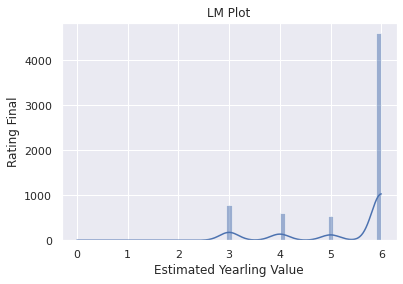

In [152]:
sns.histplot(data = data_df, x = 'runs', kde = True).set(xlabel = 'Estimated Yearling Value', ylabel = 'Rating Final', title = 'LM Plot')

In [153]:
data_df.groupby('runs').count() # we see horses with no runs dont have a rating and can be removed

,Name,Year,Sex,Sire,rating_final,trainer_horses,final_sale_price,est_yearling_value,log_est_yearling_value,log_trainer_horses,Filly,Gelding
runs,,,,,,,,,,,,
0.0,9,9,9,9,0,9,0,9,9,9,9,9
3.0,785,785,785,785,785,647,405,785,785,647,785,785
4.0,613,613,613,613,613,420,304,613,613,420,613,613
5.0,536,536,536,536,536,338,263,536,536,338,536,536
6.0,4602,4602,4602,4602,4601,3290,1662,4602,4602,3290,4602,4602


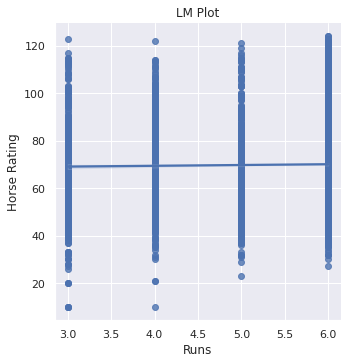

In [154]:
data_df = data_df.loc[data_df['runs'] > 0]
sns.lmplot(data = data_df, x = 'runs', y = 'rating_final').set(xlabel='Runs', ylabel='Horse Rating', title = 'LM Plot') #we can see there isnt a usefull relationship between runs and rating_final. this variable wont be used in the final model.

In [155]:
data_df_no_nans = data_df.loc[~(data_df['runs'].isna()) & ~(data_df['rating_final'].isna())]
r = pearson_r(data_df_no_nans['runs'], data_df_no_nans['rating_final'])

# Print the result
print(r) ## litlle correlation so variable will be removed

0.020279381092016532


In [156]:
data_df = data_df.drop(columns = 'runs')

# rating_final - Target Variable (Horse Ability)


[Text(0.5, 0, 'Rating Final')]

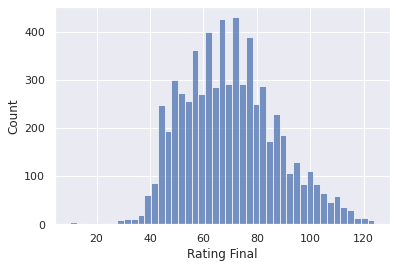

In [157]:
##EDA of rating_final variable (horse_ability)
sns.histplot(data = data_df, x = 'rating_final').set(xlabel = 'Rating Final')
##The data is normaly distributed

In [158]:
data_df['rating_final'].min(), data['rating_final'].max() #can see there is some outliers rated 10 - this is a very low level of racing. a rating of 45 is the lowest a horse is allowed to run off of i will remove any horse rated lower then 20


(10.0, 124.0)

In [159]:
data_df = data_df.loc[data_df['rating_final'] > 20]

# Modeling
##Fitting A Model

In [160]:
#since I am happy with the distributions of our target and predictor variable i will fit a linear model that aims to predict horse ability.

In [161]:
model_df = data_df[['rating_final', 'log_trainer_horses', 'log_est_yearling_value', 'Filly', 'Gelding']].dropna()
model_df.head()

,rating_final,log_trainer_horses,log_est_yearling_value,Filly,Gelding
1,49.0,2.639057,8.460623,0,1
3,71.0,3.713572,10.868568,1,0
4,42.0,3.555348,8.731928,1,0
5,43.0,4.700480,9.952278,1,0
6,80.0,2.079442,10.003333,0,1


In [162]:
#code taken from Datacamp.
y = model_df['rating_final'] # variable we want to predict
X = model_df.drop(columns = 'rating_final')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state= 3) # setting test size to 0.25 and random stat to 3, setting a random state means the results are reproducable.

reg = LinearRegression()
reg.fit(X_train, y_train) # fitting a linear model on our training datasets. using the variables in the x_train dataset to model the target variable in the y dataset (rating_final)
y_pred = reg.predict(X_test) # produces the predictions the model would make on our test dataset. 
print("Intercept:", reg.intercept_,  "\nCoefficients:", reg.coef_ )

Intercept: 10.355762165055538 
Coefficients: [  3.87750456   5.27269526 -11.69344216  -7.59331125]


In [163]:
np.log(2)*5.08

3.521187677244522

# Analysing The model

In [164]:
# Compute R-squared
r_squared = reg.score(X_test, y_test)

# Compute RMSE
rmse = mean_squared_error(y_test, y_pred)

# Print the metrics
print("R^2: {}".format(r_squared))
print("RMSE: {}".format(rmse))

R^2: 0.17142948206883546
RMSE: 239.09001788105323


In [165]:
# Create a KFold object
kf = KFold(n_splits=25, shuffle=True, random_state=5)

reg = LinearRegression()

# Compute 6-fold cross-validation scores
cv_scores = cross_val_score(reg, X, y, cv=kf)

# Print scores
print(cv_scores) #ranges from 0.069 to 0.312 based on how the model is split

[0.15579114 0.2307631  0.16361556 0.1651239  0.2151941  0.20588153
 0.24625882 0.31214158 0.21223976 0.16101985 0.24571486 0.26257238
 0.19457397 0.20516578 0.19339398 0.06916    0.17301519 0.17451537
 0.15169565 0.20529855 0.27831183 0.2312262  0.16227936 0.22894756
 0.23462755]


In [166]:
cv_scores.min(), cv_scores.max()

(0.06915999727828792, 0.3121415849165847)

In [167]:
# Print the mean
print(np.mean(cv_scores))

# Print the standard deviation
print(np.std(cv_scores))

# Print the 95% confidence interval
print(np.quantile(cv_scores, [0.025, 0.975]))

#we are 95% sure the models r score will lie in the range [0.11868139 0.29184373]

0.2031411026649973
0.048734126444025735
[0.11868139 0.29184373]


#Boosting

In [168]:
##Hyper param tuning is not suitable for a linear model. 
##since our model is poor I feel boosting could help. Adoboosting looks the most suitable for linear regression.

In [ ]:
##can include fitting errors if having time. 

In [177]:
#taken from datacamp.
# Instantiate the default linear regression model
reg = LinearRegression()

# Build and fit an AdaBoost regressor
reg_ada = AdaBoostRegressor(base_estimator=reg, n_estimators=20, random_state=3)
reg_ada.fit(X_train, y_train)

# Calculate the predictions on the test set
pred = reg_ada.predict(X_test)

r_squared = reg_ada.score(X_test, y_test)

# Evaluate the performance using the RMSE
rmse = np.sqrt(mean_squared_error(y_test, pred))

print("R^2: {}".format(r_squared))
print("RMSE: {}".format(rmse))

R^2: 0.1519274622861585
RMSE: 15.643448046761863


In [179]:
# Build and fit a tree-based AdaBoost regressor
reg_ada = AdaBoostRegressor(n_estimators=12, random_state=500)
reg_ada.fit(X_train, y_train)

# Calculate the predictions on the test set
pred = reg_ada.predict(X_test)

r_squared = reg_ada.score(X_test, y_test)

# Evaluate the performance using the RMSE
rmse = np.sqrt(mean_squared_error(y_test, pred))
print("R^2: {}".format(r_squared))
print('RMSE: {:.3f}'.format(rmse))

R^2: 0.16086503141007924
RMSE: 15.561


In [ ]:
# Build and fit an AdaBoost regressor
reg_ada = AdaBoostRegressor(n_estimators=100, learning_rate=0.01, random_state=500)
reg_ada.fit(X_train, y_train)

# Calculate the predictions on the test set
pred = reg_ada.predict(X_test)

# Evaluate the performance using the RMSE
rmse = np.sqrt(mean_squared_error(y_test, pred))
print('RMSE: {:.3f}'.format(rmse))

In [ ]:
# Build and fit linear regression model
reg_lm = LinearRegression()
reg_lm.fit(X_train, y_train)

# Calculate the predictions on the test set
pred = reg_lm.predict(X_test)

# Evaluate the performance using the RMSE
rmse = np.sqrt(mean_squared_error(y_test, pred))
print('RMSE: {:.3f}'.format(rmse))

In [ ]:
y_train_error = pred_train - y_train
y_test_error = pred_test - y_test

# Fit a linear regression model to the previous errors
reg_error = LinearRegression()
reg_error.fit(X_train_pop, y_train_error)

# Calculate the predicted errors on the test set
pred_error = reg_error.predict(X_test_pop)

# Evaluate the updated performance
rmse_error = np.sqrt(mean_squared_error(y_test_error, pred_error))
print('RMSE: {:.3f}'.format(rmse_error))

In [ ]:
##adaboost datacamp.